# Lab 3: Iterative Algorithms

> Date: 10/25/2024
> Author: Adam Haile, Leigh Goetsch, Aiden Miller
> Class: CSC3310
>
> ### Learning Outcomes
>
> - Design an algorithm for a given computational problem statement
> - Justify the correctness of an algorithm
> - Perform asymptotic complexity analysis of the run time of an algorithm
> - Generate test cases for an algorithm
> - Correctly implement an algorithm from pseudocode
> - Design and execute benchmarks for an algorithm


## Pseudocode

```python
inclusive = false
points = [list of polygon points]
distinct_point = (x, y)

vectors = drawVectors(points)
right_line = rightVector(distinct_point)

wn = 0
for vector in vectors:
    if counterclockwise_check(vector, right_line) or onsegment_check(vector, right_line, inclusive):
        wn += 1

return wn % 2 == 1
```
## Imports

In [36]:
from typing import List, Tuple
from pydantic import BaseModel

import matplotlib.pyplot as plt

import random as rd
import polygenerator as pg
import time
import statistics as st

rd.seed(42)

## Class and Functions
### Setup and Helper Functions

In [37]:
class Vector(BaseModel):
    """
    Represents a vector in 2D space
    """
    point_1: Tuple[float, float]
    point_2: Tuple[float, float]

def get_right_line(distinct_point: Tuple[float, float]) -> Vector:
    """
    Get the infinite line that is to the right of the distinct point
    """
    return Vector(point_1=distinct_point, point_2=(float('inf'), distinct_point[1]))

def draw_vectors(points: List[Tuple[float, float]]) -> List[Vector]:
    """
    Get a list of vectors from a list of points
    """
    vectors = []
    for i in range(len(points)):
        if i == len(points) - 1:
            vectors.append(Vector(point_1=points[i], point_2=points[0]))
        else:
            vectors.append(Vector(point_1=points[i], point_2=points[(i+1)]))

    return vectors

def plot_polygon(vectors: List[Vector], right_line: Vector) -> None:
    """
    Plot the polygon vectors and the right line
    """
    for vector in vectors:
        x_values = [vector.point_1[0], vector.point_2[0]]
        y_values = [vector.point_1[1], vector.point_2[1]]
        plt.plot(x_values, y_values, marker='o')

    plt.scatter(right_line.point_1[0], right_line.point_1[1])
    plt.plot([right_line.point_1[0], min(3, right_line.point_2[0])], [
            right_line.point_1[1], right_line.point_2[1]], linestyle='--')
    # plt.xlim(-1, 2)
    # plt.ylim(-1, 2)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Polygon Vectors')
    plt.grid(True)
    plt.show()

### Algorithm


In [38]:
def ccw(p1: Tuple[float, float], p2: Tuple[float, float], p3: Tuple[float, float]) -> bool:
    """
    Determine if three points are listed in a counterclockwise order
    Time Complexity: O(1)
    """
    return (p3[1] - p1[1]) * (p2[0] - p1[0]) > (p2[1] - p1[1]) * (p3[0] - p1[0])


def collinear(p1: Tuple[float, float], p2: Tuple[float, float], p3: Tuple[float, float]) -> bool:
    """
    Determine if three points form collinear vectors
    Time Complexity: O(1)
    """
    return (p3[1] - p1[1]) * (p2[0] - p1[0]) == (p2[1] - p1[1]) * (p3[0] - p1[0])


def on_segment(p1: Tuple[float, float], p2: Tuple[float, float], p3: Tuple[float, float]) -> bool:
    """
    Determine if a point is on a segment
    Time Complexity: O(1)
    """
    return collinear(p1, p2, p3) and min(p1[0], p2[0]) <= p3[0] <= max(p1[0], p2[0]) and min(p1[1], p2[1]) <= p3[1] <= max(p1[1], p2[1])


def intersect(v1: Vector, v2: Vector, check_edge: bool) -> bool:
    """
    Determine if two vectors intersect
    Time Complexity: O(1)
    """
    if ccw(v1.point_1, v2.point_1, v2.point_2) != ccw(v1.point_2, v2.point_1, v2.point_2) and ccw(v1.point_1, v1.point_2, v2.point_1) != ccw(v1.point_1, v1.point_2, v2.point_2):
        return True

    if check_edge and (on_segment(v2.point_1, v2.point_2, v1.point_1) or on_segment(v2.point_1, v2.point_2, v1.point_2)):
        return True

    return check_edge and (on_segment(v1.point_1, v1.point_2, v2.point_1) or on_segment(v1.point_1, v1.point_2, v2.point_2))


def inside_polygon(vectors, point, inclusive=True) -> bool:
    """
    Determine if a point is inside a polygon
    Time Complexity: O(n) where n is the number of vectors in the polygon
    """

    right_line = Vector(point_1=point, point_2=(float('inf'), point[1]))

    return sum(intersect(vector, right_line, inclusive) for vector in vectors) % 2 == 1

## Test Cases

In [39]:
points = [(0.5, 0), (0, 1.5), (1, 2.5), (2, 1.5), (1.5, 0)]
distinct_point = (1, 1)

vectors = draw_vectors(points)

vectors

[Vector(point_1=(0.5, 0.0), point_2=(0.0, 1.5)),
 Vector(point_1=(0.0, 1.5), point_2=(1.0, 2.5)),
 Vector(point_1=(1.0, 2.5), point_2=(2.0, 1.5)),
 Vector(point_1=(2.0, 1.5), point_2=(1.5, 0.0)),
 Vector(point_1=(1.5, 0.0), point_2=(0.5, 0.0))]

In [40]:
right_line = get_right_line(distinct_point)
right_line

Vector(point_1=(1.0, 1.0), point_2=(inf, 1.0))

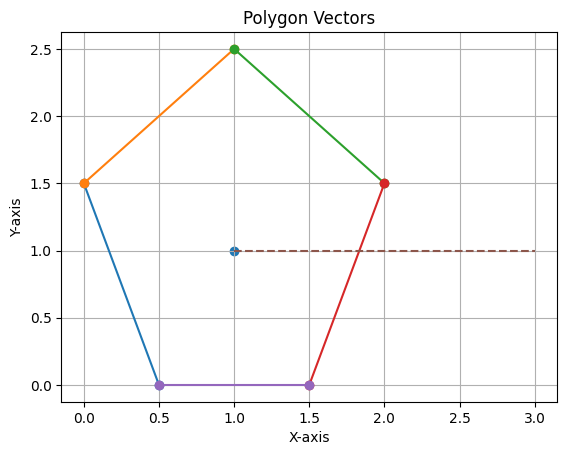

In [41]:
plot_polygon(vectors, right_line)

In [42]:
inside_polygon(vectors, distinct_point)

True

## Benchmarking

In [43]:
# Polygons
polygon_sizes = [3, 5, 10, 50, 100, 500, 1000, 2000]
polygons = [pg.random_polygon(size) for size in polygon_sizes]

# Points
points = [(rd.uniform(0, 1), rd.uniform(0, 1)) for _ in range(3)]

def benchmark_inside_polygon(polygon, point):
    """
    Benchmark the inside_polygon function
    """
    start_time = time.perf_counter()
    polygon = draw_vectors(polygon)
    inside_polygon(polygon, point)
    end_time = time.perf_counter()
    elapsed = end_time - start_time
    return elapsed

results = []
# Check if points are inside polygons
for polygon in polygons:
    point_results = []
    for point in points:
        point_results.append(benchmark_inside_polygon(polygon, point))
        # plot_polygon(draw_vectors(polygon), get_right_line(point))
    results.append(st.mean(point_results))


Estimated Slope: 0.9226373549091558
Complexity: Sub-linear (e.g., log n)



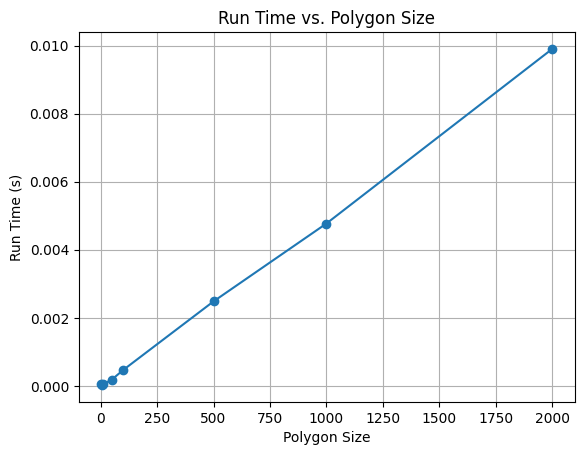

In [44]:
import numpy as np
from scipy.stats import linregress

# fit a linear regression model to the log of the list
# sizes (s) and run times (r) to estimate the slope (m)
# log r = m log s + b


def estimate_slope(list_sizes, run_times):
    '''
    Function takes a list of list sizes and a list of run times
    and returns the slope of the linear regression model.
    '''
    m, b, _, _, _ = linregress(np.log(list_sizes), np.log(run_times))
    return m


def get_complexity(m):
    '''
    Function takes the slope of the linear regression model
    and returns the complexity of the algorithm.
    '''
    if m == 0:
        return "Constant"
    elif m < 1:
        return "Sub-linear (e.g., log n)"
    elif m == 1:
        return "Linear"
    elif m > 1 and m < 2:
        return "Between linear and quadratic (e.g., n log n)"
    elif m == 2:
        return "Quadratic (e.g., n^2)"
    elif m > 2 and m < 3:
        return "Between quadratic and cubic (e.g., n^2 log n)"
    elif m == 3:
        return "Cubic (e.g., n^3)"
    else:
        return "Out of Scope"


# Validate the the formal run time complexity of the algorithms
m = estimate_slope(polygon_sizes, results)
complexity = get_complexity(m)
print(f"Estimated Slope: {m}")
print(f"Complexity: {complexity}")
print()

# Plot the results
plt.plot(polygon_sizes, results, marker='o')
plt.xlabel('Polygon Size')
plt.ylabel('Run Time (s)')
plt.title('Run Time vs. Polygon Size')
plt.grid(True)
plt.show()

In [45]:
def plot_vectors(vectors: List[Vector], distinct_point: Tuple[float, float] = None) -> plt.figure:
    #create figure\n",
    plt.figure(figsize=(4, 4)),
    for vector in vectors:
        x_values = [vector.point_1[0], vector.point_2[0]]
        y_values = [vector.point_1[1], vector.point_2[1]]
        plt.plot(x_values, y_values, marker='o')
    
    if distinct_point != None:
        plt.scatter(distinct_point[0], distinct_point[1])
        plt.plot([right_line.point_1[0], min(3, right_line.point_2[0])], 
             [right_line.point_1[1], right_line.point_2[1]], linestyle='--')
    plt.xlim(-1, 3)
    plt.ylim(-1, 3)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Polygon Vectors')
    plt.grid(True)
    # return figure
    return plt.gca()

plot = True

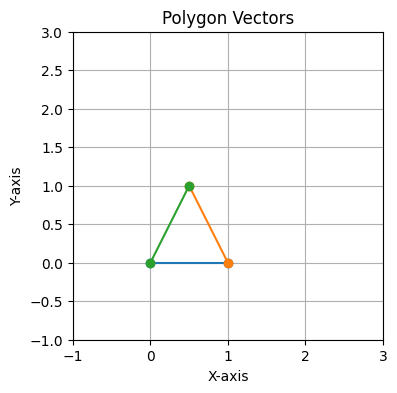

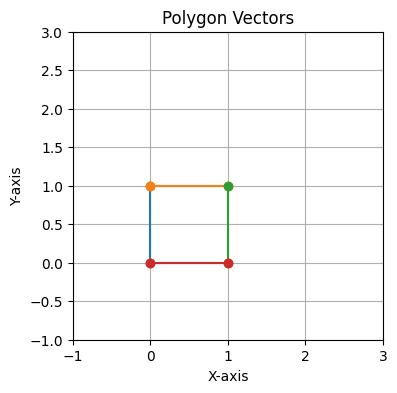

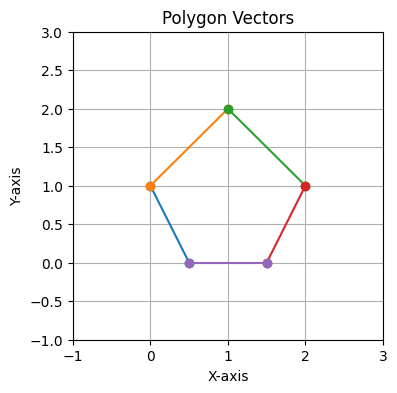

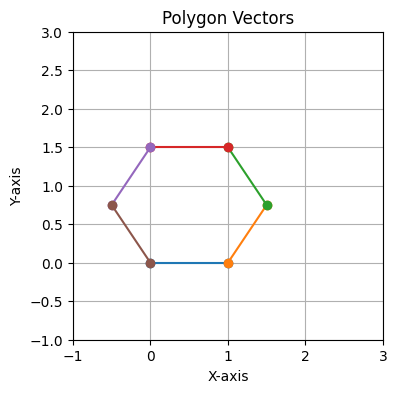

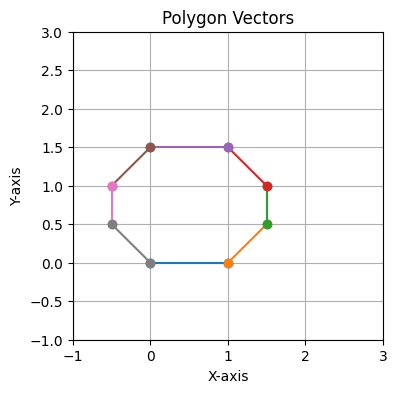

In [46]:
# Test 1: Basic shapes, i.e square, triangle, pentagon, hexagon, octagon
triangle_points = [(0, 0), (1, 0), (0.5, 1)]
square_points = [(0, 0), (0, 1), (1, 1), (1, 0)]
pentagon_points = [(0.5, 0), (0, 1), (1, 2), (2, 1), (1.5, 0)]
hexagon_points = [(0, 0), (1, 0), (1.5, 0.75), (1, 1.5), (0, 1.5), (-0.5, 0.75)]
octagon_points = [(0, 0), (1, 0), (1.5, 0.5), (1.5, 1), (1, 1.5), (0, 1.5), (-0.5, 1), (-0.5, 0.5)]

square_vectors = draw_vectors(square_points)
triangle_vectors = draw_vectors(triangle_points)
pentagon_vectors = draw_vectors(pentagon_points)
hexagon_vectors = draw_vectors(hexagon_points)
octagon_vectors = draw_vectors(octagon_points)

#plot shapes
if plot:
    plot_vectors(triangle_vectors)
    plot_vectors(square_vectors)
    plot_vectors(pentagon_vectors)
    plot_vectors(hexagon_vectors)
    plot_vectors(octagon_vectors)

# Cases
# Positive case, center of polygon
test_pt = (0.5, 0.5)
assert inside_polygon(triangle_vectors, test_pt) == True
assert inside_polygon(square_vectors, test_pt) == True
assert inside_polygon(pentagon_vectors, test_pt) == True
assert inside_polygon(hexagon_vectors, test_pt) == True
assert inside_polygon(octagon_vectors, test_pt) == True

# Negative case, outside 3x3 square of points outside polygon
test_points = [(-1, -1), (1, -1), (3, -1), (3, 0.5), (3, 3), (0.5, 3), (-1, 3), (-1, 0.5)]
assert all(inside_polygon(triangle_vectors, pt) == False for pt in test_points)
assert all(inside_polygon(square_vectors, pt) == False for pt in test_points)
assert all(inside_polygon(pentagon_vectors, pt) == False for pt in test_points)
assert all(inside_polygon(hexagon_vectors, pt) == False for pt in test_points)
assert all(inside_polygon(octagon_vectors, pt) == False for pt in test_points)

In [50]:
# Test 2: Concave polygons

#nested list comprehension to double the values for each tuple in the list
# cancave1 = [(2*x, 2*y) for x, y in pg.random_star_shaped_polygon(4)]
# cancave2 = [(2*x, 2*y) for x, y in pg.random_star_shaped_polygon(5)]
# cancave3 = [(2*x, 2*y) for x, y in pg.random_star_shaped_polygon(6)]
# concave4 = [(2*x, 2*y) for x, y in pg.random_star_shaped_polygon(7)]
# concave5 = [(2*x, 2*y) for x, y in pg.random_star_shaped_polygon(8)]

# cancave1_vectors = draw_vectors(cancave1)
# cancave2_vectors = draw_vectors(cancave2)
# cancave3_vectors = draw_vectors(cancave3)
# concave4_vectors = draw_vectors(concave4)
# concave5_vectors = draw_vectors(concave5)

In [66]:
cancave1 = [(1.0770230274977621, 2.0), (1.0701214824718508, 1.58083570903468), (0.0, 0.0), (2.0, 0.3280763018072074)]
cancave2 = [(2.0, 1.1750318240428033), (1.9221019042924747, 2.0), (0.44248435290975957, 1.4793109390850825), (0.0, 1.4913457706722701), (0.06830485309367998, 0.0)]
cancave3 = [(1.1353953052877837, 0.8619812579522), (0.953073457124504, 1.0174427304337217), (2.0, 1.5961192650889844), (0.41295676178745566, 2.0), (0.0, 1.414657286604214), (1.9647627125185438, 0.0)]
concave4 = [(2.0, 0.8700732229633639), (0.0, 2.0), (0.39547774682317083, 0.003916977341347422), (0.46990464802695203, 0.0), (1.475853861061979, 0.27025365835577414), (1.7612717964530658, 0.7860492477511123), (1.4969619566741321, 0.7911312296845074)]
concave5 = [(1.9999999999999998, 1.8394892346839924), (1.4342282628973673, 2.0), (0.3159937397907171, 1.5898477952887802), (0.40740519742818926, 1.1231500217492716), (0.0, 0.9281072619689151), (0.5793287716307272, 0.954722493942688), (1.2550474040617023, 0.5755607503698047), (1.3444909644895129, 0.0)]

cancave1_vectors = draw_vectors(cancave1)
cancave2_vectors = draw_vectors(cancave2)
cancave3_vectors = draw_vectors(cancave3)
concave4_vectors = draw_vectors(concave4)
concave5_vectors = draw_vectors(concave5)

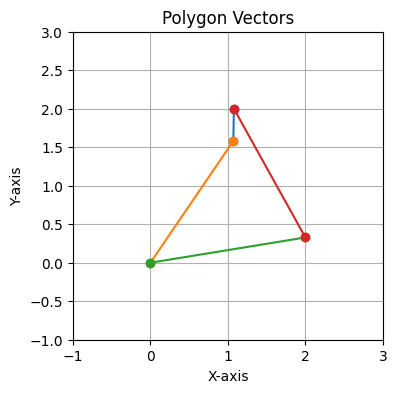

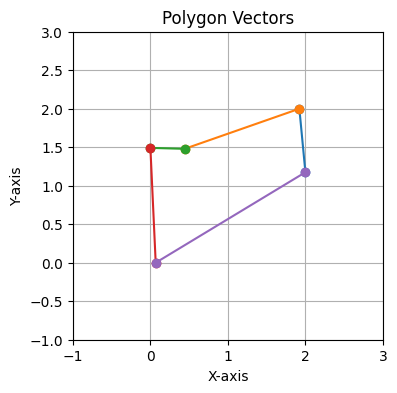

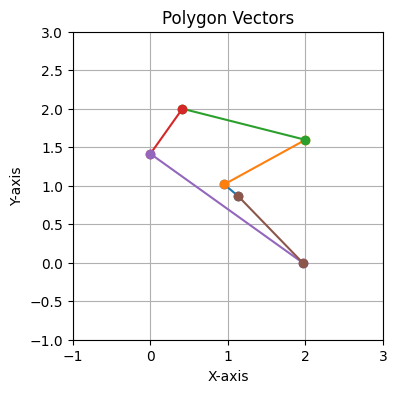

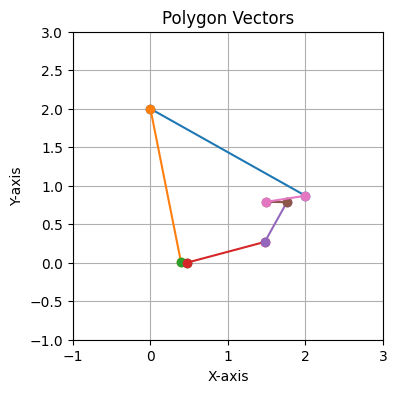

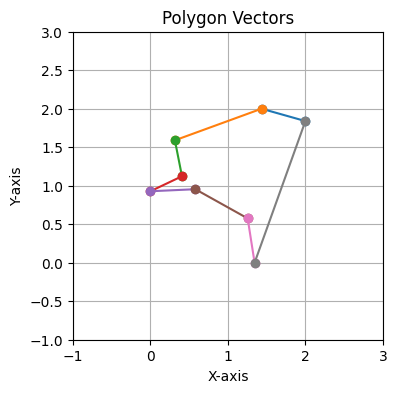

In [68]:
#plot shapes
if plot:
    plot_vectors(cancave1_vectors)
    plot_vectors(cancave2_vectors)
    plot_vectors(cancave3_vectors)
    plot_vectors(concave4_vectors)
    plot_vectors(concave5_vectors)

# Positive case, center of polygon
test_pt = (1, 1)
assert inside_polygon(cancave1_vectors, test_pt) == True
assert inside_polygon(cancave2_vectors, test_pt) == True
assert inside_polygon(cancave3_vectors, (1, 1.5)) == True
assert inside_polygon(concave4_vectors, test_pt) == True
assert inside_polygon(concave5_vectors, test_pt) == True

# Negative case, inside the concave part of the polygon
assert inside_polygon(cancave1_vectors, (1, 1.75)) == False
assert inside_polygon(cancave2_vectors, (0.5, 1.6)) == False
assert inside_polygon(cancave3_vectors, (1.5, 1)) == False
assert inside_polygon(concave4_vectors, (1.9, 0.5)) == False
assert inside_polygon(concave5_vectors, (1, 0.5)) == False
assert inside_polygon(concave5_vectors, (0.2, 1.5)) == False